In [2]:
# Import Libraries
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'   # Background_color = white (fot matplotlib figures)

In [3]:
# Feedfoward neural network
class Func_1_Model1(nn.Module):
    def __init__(self, in_size, dense_size_1, dense_size_2, dense_size_3, 
                 dense_size_4, dense_size_5):
        super().__init__()
        # input layer
        self.in_layer = nn.Linear(in_size, in_size)
        # dense layer 1
        self.dense1 = nn.Linear(in_size, dense_size_1)
        # dense layer 2
        self.dense2 = nn.Linear(dense_size_1, dense_size_2)
        # dense layer 3
        self.dense3 = nn.Linear(dense_size_2, dense_size_3)
        # dense layer 4
        self.dense4 = nn.Linear(dense_size_3, dense_size_4)
        # dense layer 5
        self.dense5 = nn.Linear(dense_size_4, dense_size_5)
        
    def forward(self, input_data):
        input_data = input_data.view(input_data.size(0), -1)
        
        # outputs using input layer
        out = self.in_layer(input_data)
        # activation function for input layer
        out = F.leaky_relu(out)
        
        # outputs using dense layer 1
        out = self.dense1(out)
        # activation function for dense layer 1
        out = F.leaky_relu(out)
        
        # outputs using dense layer 2
        out = self.dense2(out)
        # activation function for dense layer 2
        out = F.leaky_relu(out)
        
        # outputs using dense layer 3
        out = self.dense3(out)
        # activation function for dense layer 3
        out = F.leaky_relu(out)
        
        # outputs using dense layer 4
        out = self.dense4(out)
        # activation function for dense layer 4
        out = F.leaky_relu(out)
       
        # predictions using dense layer 5
        out = self.dense5(out)
        return out
 
    def train(self, batch):
        x, y = batch 
        y = y.view(y.size(0), -1)
        out = self(x)                  # Generate predictions
        loss = F.mse_loss(out, y)      # Calculate loss
        return loss
    
    def validate(self, batch):
        x, y = batch 
        y = y.view(y.size(0), -1)
        out = self(x)                    # Generate predictions
        loss = F.mse_loss(out, y)        # Calculate loss
        return {'val_loss': loss}
        
    def validation_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [5]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [6]:
def evaluate(model, val_dl):
    outputs = [model.validate(batch) for batch in val_dl]
    return model.validation_end(outputs)

def fit(epochs, lr, model, train_dl, val_dl, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_dl:
            loss = model.train(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_dl)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

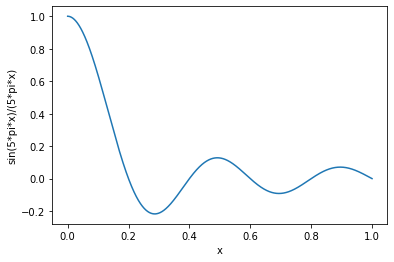

In [7]:
inputs = np.array([x/7001 for x in range(1,7001)], dtype='double')
array1 = np.sin(5*np.pi*inputs)
array2 = np.array(5*np.pi*inputs)
targets = np.array(array1/array2, dtype='double')

plt.plot(inputs,targets)
plt.xlabel('x')
plt.ylabel('sin(5*pi*x)/(5*pi*x)')
plt.show()

In [8]:
# Convert inputs and targets to tensors
inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)

# Define dataset
AllData = TensorDataset(inputs, targets)

In [9]:
# Separate datasets for training, validation, and testing
val_size = 1000
test_size = 1000
train_size = len(AllData) - val_size - test_size

train_ds, val_ds, test_ds = random_split(AllData, [train_size, val_size, test_size])

# Print length of the datasets
len(train_ds), len(val_ds), len(test_ds)

(5000, 1000, 1000)

In [10]:
batch_size = 500

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=1, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=1, pin_memory=True)

In [11]:
for x, _ in train_dl:
    print('x.shape:', x.shape)
    break
    
for y, _ in val_dl:
    print('y.shape:', y.shape)
    break 

x.shape: torch.Size([500])
y.shape: torch.Size([500])


In [12]:
# Define NN layer sizes
input_size = 1
dense_size_1 = 10
dense_size_2 = 18
dense_size_3 = 15
dense_size_4 = 4
dense_size_5 = 1

In [13]:
# Define NN model1
model1 = Func_1_Model1(input_size, dense_size_1, dense_size_2, dense_size_3,
                 dense_size_4, dense_size_5).double()

count_parameters(model1)

574

In [14]:
device = get_default_device()
device

device(type='cuda')

In [15]:
# Transfer dataset & model to GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model1, device)

Func_1_Model1(
  (in_layer): Linear(in_features=1, out_features=1, bias=True)
  (dense1): Linear(in_features=1, out_features=10, bias=True)
  (dense2): Linear(in_features=10, out_features=18, bias=True)
  (dense3): Linear(in_features=18, out_features=15, bias=True)
  (dense4): Linear(in_features=15, out_features=4, bias=True)
  (dense5): Linear(in_features=4, out_features=1, bias=True)
)

In [ ]:
history = [evaluate(model1, val_dl)]
history

In [ ]:
history += fit(20000, 0.001, model1, train_dl, val_dl)

In [ ]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

In [ ]:
# Save model and losses
torch.save(model1.state_dict(), 'HW_1_1_func1model1_v1.pth')
pd.DataFrame(losses).to_csv('HW_1_1_func1model1_v1_losses.csv',index=False)

**Second session (beyond 20,000 epochs)**

In [16]:
model1.load_state_dict(torch.load('../input/dl-hw-1-1-func-1-model1/HW_1_1_func1model1_v1.pth'))
to_device(model1, device)
history = [evaluate(model1, val_dl)]
history

[{'val_loss': 0.007948246042873974}]

In [18]:
history += fit(10000, 0.001, model1, train_dl, val_dl)

Epoch [0], val_loss: 0.0079
Epoch [1], val_loss: 0.0079
Epoch [2], val_loss: 0.0080
Epoch [3], val_loss: 0.0080
Epoch [4], val_loss: 0.0080
Epoch [5], val_loss: 0.0080
Epoch [6], val_loss: 0.0080
Epoch [7], val_loss: 0.0080
Epoch [8], val_loss: 0.0080
Epoch [9], val_loss: 0.0080
Epoch [10], val_loss: 0.0080
Epoch [11], val_loss: 0.0080
Epoch [12], val_loss: 0.0080
Epoch [13], val_loss: 0.0080
Epoch [14], val_loss: 0.0080
Epoch [15], val_loss: 0.0080
Epoch [16], val_loss: 0.0080
Epoch [17], val_loss: 0.0080
Epoch [18], val_loss: 0.0080
Epoch [19], val_loss: 0.0080
Epoch [20], val_loss: 0.0080
Epoch [21], val_loss: 0.0080
Epoch [22], val_loss: 0.0080
Epoch [23], val_loss: 0.0080
Epoch [24], val_loss: 0.0080
Epoch [25], val_loss: 0.0080
Epoch [26], val_loss: 0.0080
Epoch [27], val_loss: 0.0080
Epoch [28], val_loss: 0.0080
Epoch [29], val_loss: 0.0080
Epoch [30], val_loss: 0.0080
Epoch [31], val_loss: 0.0080
Epoch [32], val_loss: 0.0080
Epoch [33], val_loss: 0.0080
Epoch [34], val_loss: 0.

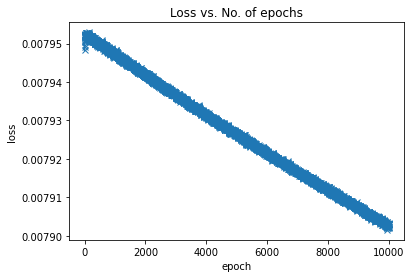

In [19]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

In [20]:
# Save model and losses
torch.save(model1.state_dict(), 'HW_1_1_func1model1_v2.pth')
pd.DataFrame(losses).to_csv('HW_1_1_func1model1_v2_losses.csv',index=False)